In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import zipfile
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
from re import I
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms,models
from torch.utils.data import Dataset, DataLoader,random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F



In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
      

In [3]:
 
train_image_dir = "/kaggle/input/ai-vs-human-generated-dataset/train_data"
test_image_dir = "/kaggle/input/ai-vs-human-generated-dataset/test_data_v2" 
train_csv = "/kaggle/input/ai-vs-human-generated-dataset/train.csv" 
test_csv = "/kaggle/input/ai-vs-human-generated-dataset/test.csv"


In [4]:
TRAIN_RATIO = 0.8

train_transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color shift
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shift
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = val_transform = transforms.Compose([
    transforms.Resize((288, 288)),  # Standard resizing
     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class CustomImageDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)  
        self.img_dir = image_dir  
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        if len(self.data.columns) > 1:
            
            img_name = str(self.data.iloc[idx,1].split("/")[-1])
            label = self.data.iloc[idx,2]
        else:
            
            img_name = str(self.data.iloc[idx,0].split("/")[-1])
            label = 0
        
        img_path = os.path.join(self.img_dir,img_name)
        image = Image.open(img_path)
        image = image.convert('RGB')

        

        if self.transform:
          image = self.transform(image)

        return image, label

In [5]:
full_train_dataset = CustomImageDataset(csv_file=train_csv, image_dir=train_image_dir, transform = train_transform)
test_dataset = CustomImageDataset(csv_file=test_csv, image_dir=test_image_dir, transform = test_transform)

train_size = int(TRAIN_RATIO * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers =4,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,num_workers =4,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers =4,pin_memory=True)

63960
15990
5540


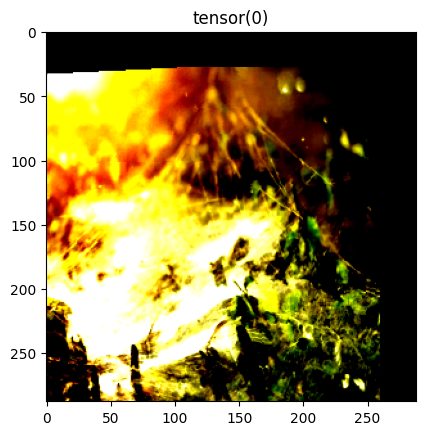

In [6]:
#Viewing an image
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

def imshow(img):
  img = img.numpy().transpose((1, 2, 0))
  img = np.clip(img, 0, 1)# converts tensor to numpy array this is to see the original image and not tensor
  plt.imshow(img)
  plt.title(labels[0])
  plt.show()

imshow(images[0])

In [7]:
##changing this to resnet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = models.regnet_y_8gf(pretrained=True)

for name, param in model.named_parameters():
    if "trunk_output.block1" in name or "trunk_output.block2" in name:  
        param.requires_grad = False

    
num_features = model.fc.in_features

num_classes = 2


model.fc = nn.Sequential(
    nn.Dropout(0.3),  
    nn.Linear(num_features, num_classes)  
)


model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
print(model)

cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_8GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_8GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_8gf-d0d0e4a8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_8gf-d0d0e4a8.pth
100%|██████████| 151M/151M [00:06<00:00, 23.3MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
      

In [8]:

num_epochs = 10

train_losses = []
train_accuracies = []
val_accuracies = []
val_losses =[]



for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch, (images, labels) in enumerate(train_dataloader):
        #print(batch, images.shape, labels.shape)
        images, labels = images.to(device), labels.to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        #backward pass + optimize
        loss.backward()
        optimizer.step()
    
        # track loss
        running_loss += loss.item()

        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

       

    train_loss = running_loss /len(train_dataloader)
    train_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # evaluation
    
    model.eval()
    
    val_loss = 0.0
    
    correct = 0
    total = 0
    
    all_predictions = []
    all_labels = []
    
   
    with torch.no_grad():
      for batch, (images, labels) in enumerate(val_dataloader):
        images, labels = images.to(device), labels.to(device)
       
        outputs = model(images)
    
        loss = criterion(outputs, labels)
        val_loss +=loss.item()
    
        #validation accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_dataloader)
    val_accuracy = 100 *correct/total
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f'Epoch {epoch+1}/{num_epochs} -> '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
              f'F1 Score: {f1:.4f}')

print("\nTraining complete!\n")

Epoch 1/10 -> Train Loss: 0.0637, Train Acc: 97.64%, Val Loss: 0.0310, Val Acc: 98.84%, F1 Score: 0.9884
Epoch 2/10 -> Train Loss: 0.0292, Train Acc: 98.92%, Val Loss: 0.0223, Val Acc: 99.21%, F1 Score: 0.9921
Epoch 3/10 -> Train Loss: 0.0217, Train Acc: 99.26%, Val Loss: 0.0206, Val Acc: 99.33%, F1 Score: 0.9933
Epoch 4/10 -> Train Loss: 0.0188, Train Acc: 99.34%, Val Loss: 0.0180, Val Acc: 99.25%, F1 Score: 0.9925
Epoch 5/10 -> Train Loss: 0.0156, Train Acc: 99.45%, Val Loss: 0.0181, Val Acc: 99.36%, F1 Score: 0.9936
Epoch 6/10 -> Train Loss: 0.0130, Train Acc: 99.53%, Val Loss: 0.0220, Val Acc: 99.27%, F1 Score: 0.9927
Epoch 7/10 -> Train Loss: 0.0122, Train Acc: 99.58%, Val Loss: 0.0174, Val Acc: 99.42%, F1 Score: 0.9942
Epoch 8/10 -> Train Loss: 0.0112, Train Acc: 99.61%, Val Loss: 0.0144, Val Acc: 99.52%, F1 Score: 0.9952
Epoch 9/10 -> Train Loss: 0.0094, Train Acc: 99.65%, Val Loss: 0.0206, Val Acc: 99.24%, F1 Score: 0.9924
Epoch 10/10 -> Train Loss: 0.0090, Train Acc: 99.68%, V

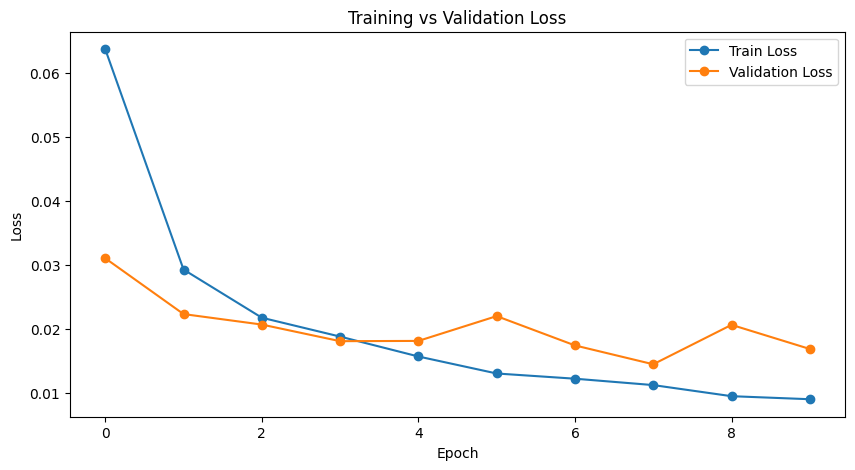

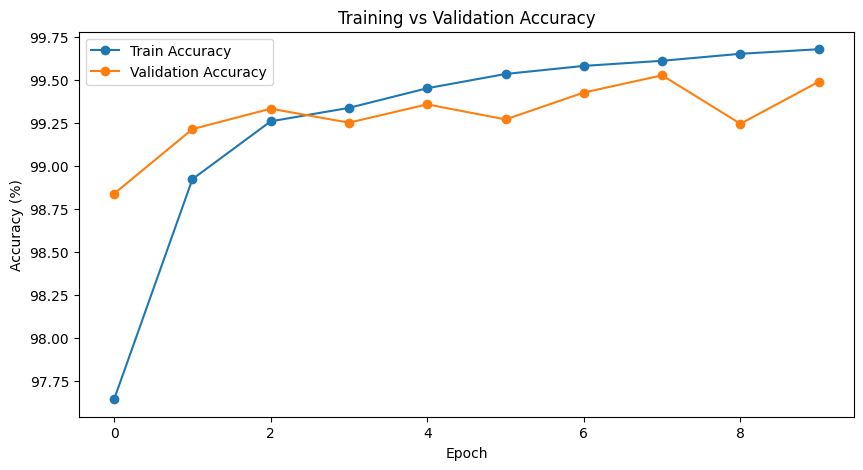

In [9]:
import matplotlib.pyplot as plt
##plotting the accuracies and loss

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label="Train Accuracy", marker='o')
plt.plot(val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [10]:
#MAKING PREDICTIONS

test_ids= test_dataset.data['id'].tolist()


predictions = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())

print(predictions[:10])

print(len(test_ids), len(predictions))
# submission DataFrame with 'id' and 'label'
submission_df = pd.DataFrame({'id': test_ids, 'label': predictions})
submission_df.to_csv('submission.csv', index=False)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
5540 5540


In [11]:
print(submission_df.head(5))

                                                  id  label
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      0
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      0
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      0
